<a href="https://colab.research.google.com/github/mirklys/little-projects/blob/main/thesis/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import copy
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
PATH_BASE = '/content/gdrive/MyDrive/Thesis Project'
PATH_DATA = os.path.join(PATH_BASE, 'data/')
PATH_NETWORKS = os.path.join(PATH_BASE, 'networks/')
PATH_PLOTS = os.path.join(PATH_BASE, 'plots/')
PATH_RESULTS = os.path.join(PATH_BASE, 'results/')
PATH_LOGS = os.path.join(PATH_BASE, 'logs/')
os.chdir(PATH_BASE)

In [4]:
def smooth(scalars: np.ndarray, weight: float) -> np.ndarray:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point 
        smoothed.append(smoothed_val)         
        last = smoothed_val                                 

    return np.array(smoothed)

In [5]:
def perf_rew_plot(data: dict, game: str):
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.winter(np.linspace(0, 1, 10))
    plt.style.use('seaborn')

    for size, v in data.items():
        fig, ax = plt.subplots(figsize=(18,9))
        #colors = plt.cm.jet(np.linspace(0, 1, len(v[0])))
        for d, color in zip(v, colors):
            dropout, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            dropout = dropout[0]
            ste_rew = np.array(std_rew)/np.sqrt(len(std_rew))
            smoothed_mean = smooth(mean_rew, .8)
            smoothed_ste = smooth(ste_rew, .8)

            ax.fill_between(np.array(x)*100, smoothed_mean-smoothed_ste, smoothed_mean+smoothed_ste, color=color, alpha=.25)
            ax.plot(np.array(x)*100, smoothed_mean, color=color, label="{}% dropout".format(int(dropout*100)), linewidth=3)
            ax.annotate(str(round(smoothed_mean[0], 1)), xy=(x[0],smoothed_mean[0]))

        ax.set_ylabel("average cumulative reward")
        ax.set_xlabel("mask size, %")
        title = "Performance of MLP policy network ({}x{}) with second masked layer at increasing dropout rates".format(size, size)
        fig.suptitle(title, fontsize=12, y=.93, fontname="sans-serif", fontweight="bold")
        ax.legend(loc="best")

        plt.savefig(os.path.join(PATH_PLOTS,game,title+".png"))

In [6]:
def std_rew_plot(data: dict, game: str):
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.winter(np.linspace(0, 1, 5))
    plt.style.use('seaborn')

    for size, v in data.items():
        fig, ax = plt.subplots(figsize=(18,9))
        #colors = plt.cm.jet(np.linspace(0, 1, len(v[0])))
        for d, color in zip(v, colors):
            dropout, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            dropout = dropout[0]
            smoothed_std = smooth(std_rew, .8)
            ax.plot(np.array(x)*100, smoothed_std, color=color, label="{}% dropout".format(int(dropout*100)), linewidth=3)


        ax.set_ylabel("standart deviation of cumulative reward")
        ax.set_xlabel("mask size, %")
        title = "Stability of MLP policy network ({}x{}) with second masked layer at increasing dropout rates".format(size, size)
        fig.suptitle(title, fontsize=12, y=.93, fontname="sans-serif", fontweight="bold")
        ax.legend(loc="best")

        plt.savefig(os.path.join(PATH_PLOTS,game,title+".png"))

In [8]:
#@title
def parse_file_name(file: str) -> tuple:
    splitted = file.split(".")
    game = splitted[0]
    size = splitted[1].split("x")[0]
    dropout = float(file.replace("{}.{}x{}.dropout".format(game, size, size), "")[1:][:-7])
    return game, int(size), dropout

In [9]:
#@title
def load(path: str, size:bool=False, dropout:bool=False) -> dict: # size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]
    assert size ^ dropout # xor
    data = defaultdict(list)
    loaded = pickle.load(open(path, 'rb'))
    x = np.arange(0., 1.05, .05, dtype=float)
    for (game, net_size, dt), v in loaded.items():
        dt = round(dt, 1)
        net_size = int(net_size)
        v = np.transpose([list(x) for x in v])
        rew, std = v[0], v[1]
        if size: data[net_size].append(np.array([[dt]*len(x), x, rew, std]))
        elif dropout: data[dt].append(np.array([[net_size]*len(x), x, rew, std]))
    return data

In [10]:
carpole_data_size = load(os.path.join(PATH_RESULTS, 'evals_cartpole.pickle'), size=True)

In [11]:
carpole_data_size.keys()

dict_keys([128, 256, 512, 1024])

In [12]:
next(iter(carpole_data_size.items()))

(128, [array([[0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
          0.00000e+00],
         [0.00000e+00, 5.00000e-02, 1.00000e-01, 1.50000e-01, 2.00000e-01,
          2.50000e-01, 3.00000e-01, 3.50000e-01, 4.00000e-01, 4.50000e-01,
          5.00000e-01, 5.50000e-01, 6.00000e-01, 6.50000e-01, 7.00000e-01,
          7.50000e-01, 8.00000e-01, 8.50000e-01, 9.00000e-01, 9.50000e-01,
          1.00000e+00],
         [5.00000e+02, 5.00000e+02, 5.00000e+02, 5.00000e+02, 5.00000e+02,
          5.00000e+02, 4.99502e+02, 4.99985e+02, 4.99913e+02, 4.96373e+02,
          5.00000e+02, 4.99752e+02, 4.89036e+02, 4.99505e+02, 4.80674e+02,
          4.96671e+02, 4.87824e+02, 4.53155e+02, 4.39598e+02, 3.42859e+02,
          9.37100e+00],
         [0.00000e+00, 

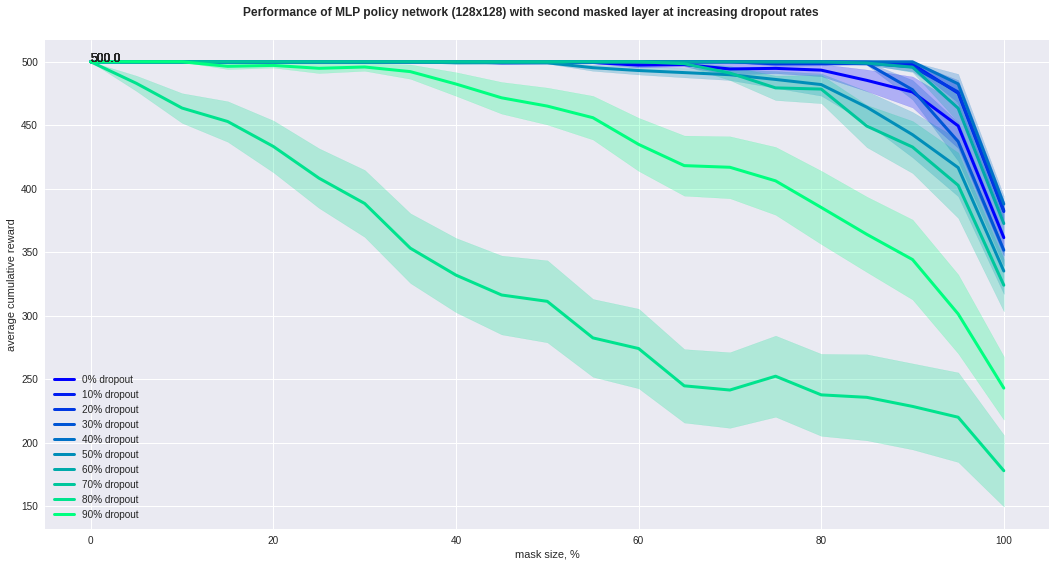

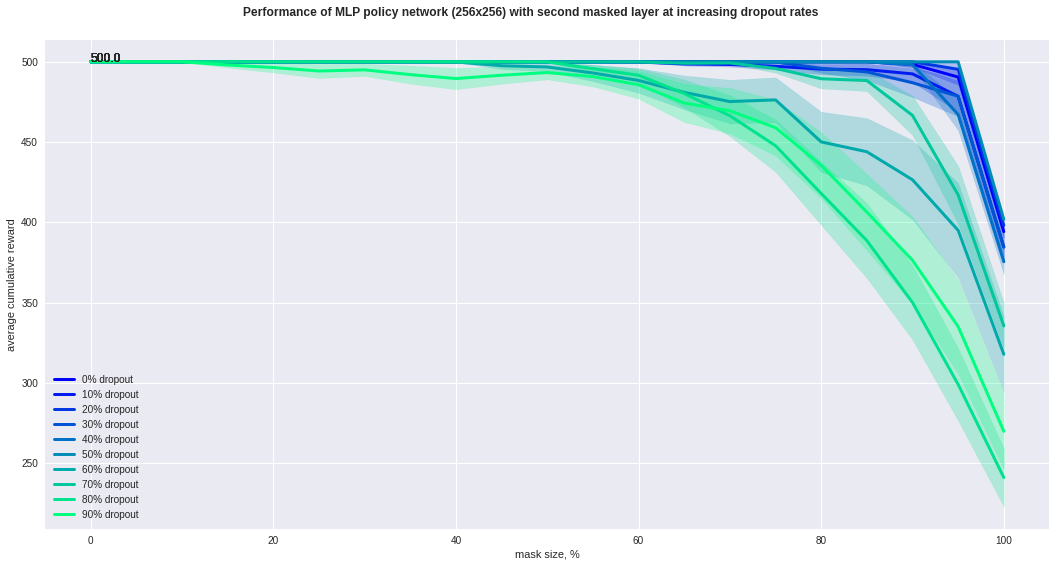

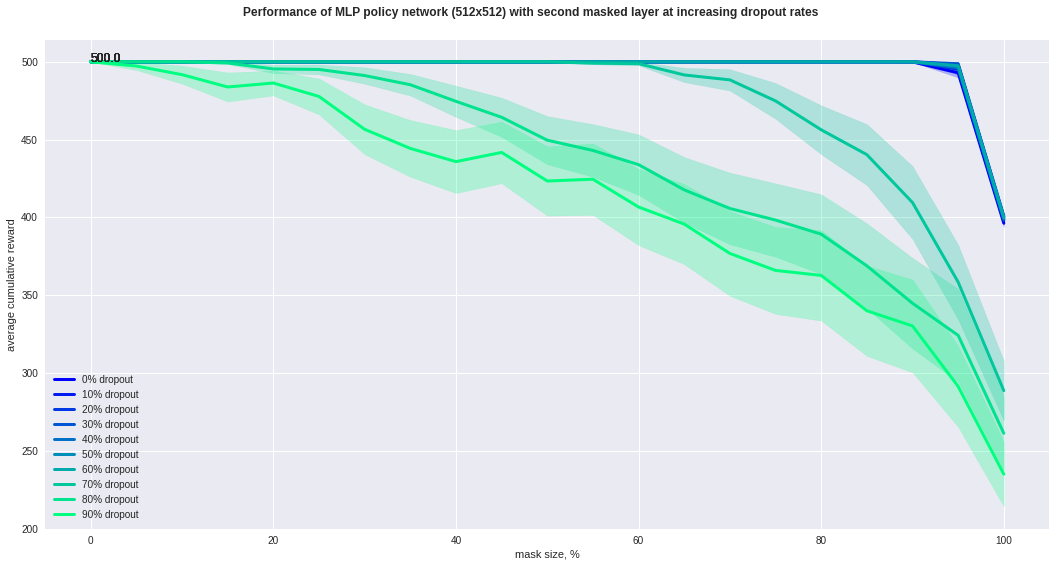

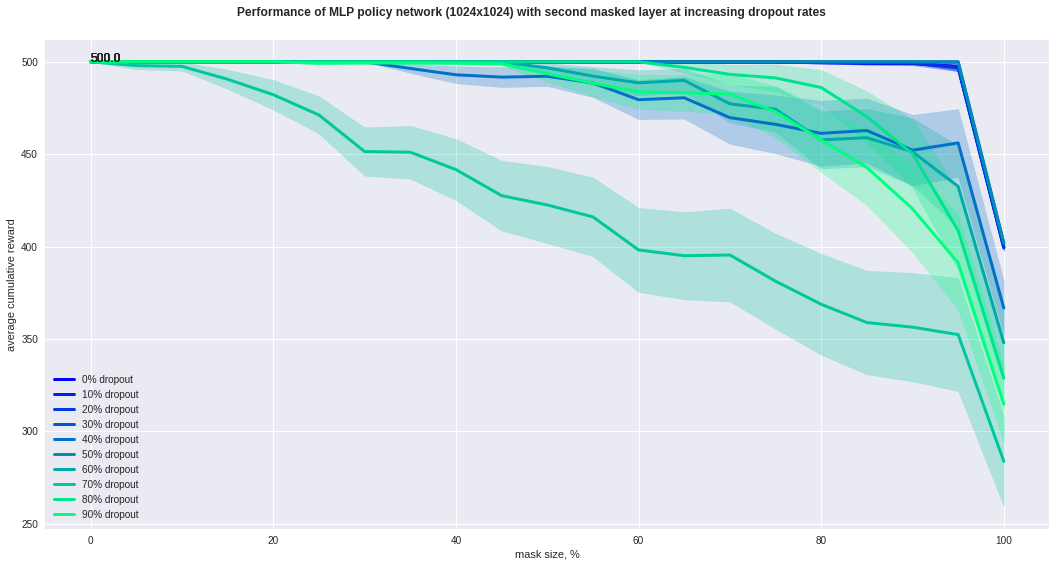

In [13]:
perf_rew_plot(carpole_data_size, 'cartpole')

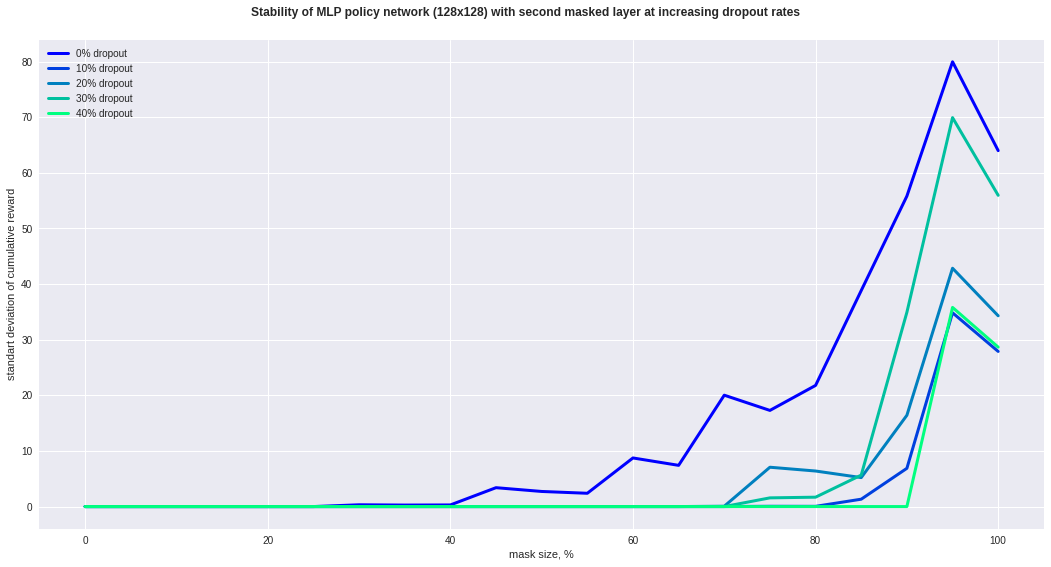

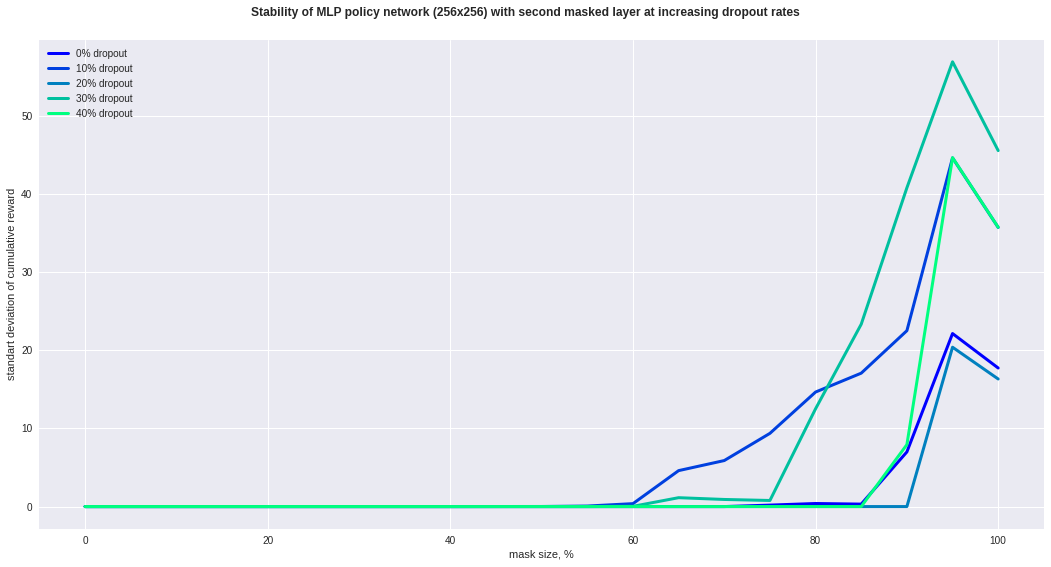

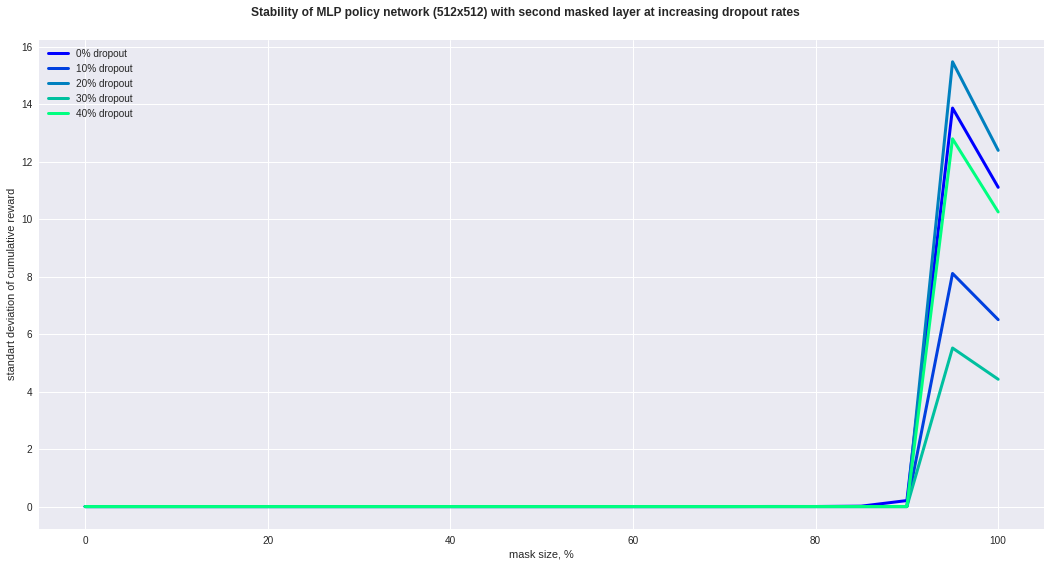

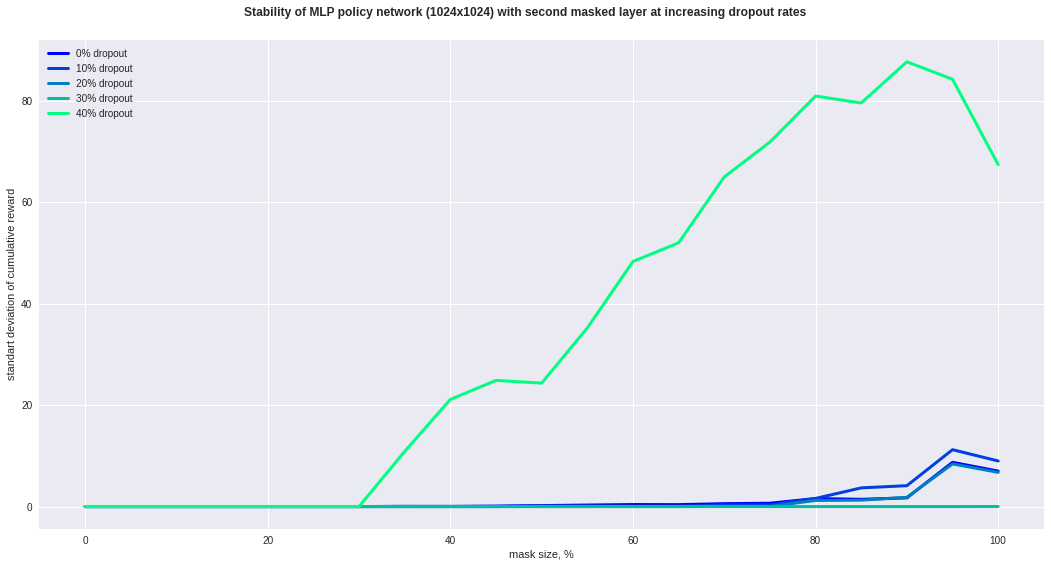

In [14]:
std_rew_plot(carpole_data_size, 'cartpole')

In [15]:
carpole_data_dropout = load(os.path.join(PATH_RESULTS, 'evals_cartpole.pickle'), dropout=True)

In [16]:
carpole_data_dropout.keys()

dict_keys([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [17]:
def perf_rew_perdropout_plot(data:dict, game:str): # probably you mixed up the legend
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.winter(np.linspace(0, 1, 4))
    plt.style.use('seaborn')

    for dropout, v in data.items():
        fig, ax = plt.subplots(figsize=(24,12))
        for d, color in zip(v, colors):
            size, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            size = size[0]
            ste_rew = np.array(std_rew)/np.sqrt(len(std_rew))
            smoothed_mean = smooth(mean_rew, .7)
            smoothed_ste = smooth(ste_rew, .7)

            ax.fill_between(np.array(x)*100, smoothed_mean-smoothed_ste, smoothed_mean+smoothed_ste, color=color, alpha=.25)
            ax.annotate(str(round(smoothed_mean[0], 1)), xy=(x[0],smoothed_mean[0]))
            ax.plot(np.array(x)*100, smoothed_mean, color=color, label="{} size".format(int(size)), linewidth=3)

        title = "Performance of MLP policy networks with second masked layer at {}% dropout".format(dropout*100)
        ax.set_ylabel("average cumulative reward")
        ax.set_xlabel("mask size, %")
        fig.suptitle(title, fontsize=12, y=.93, fontname="sans-serif", fontweight="bold")
        ax.legend(loc="best")

        plt.savefig(os.path.join(PATH_PLOTS,game,title+".png"))

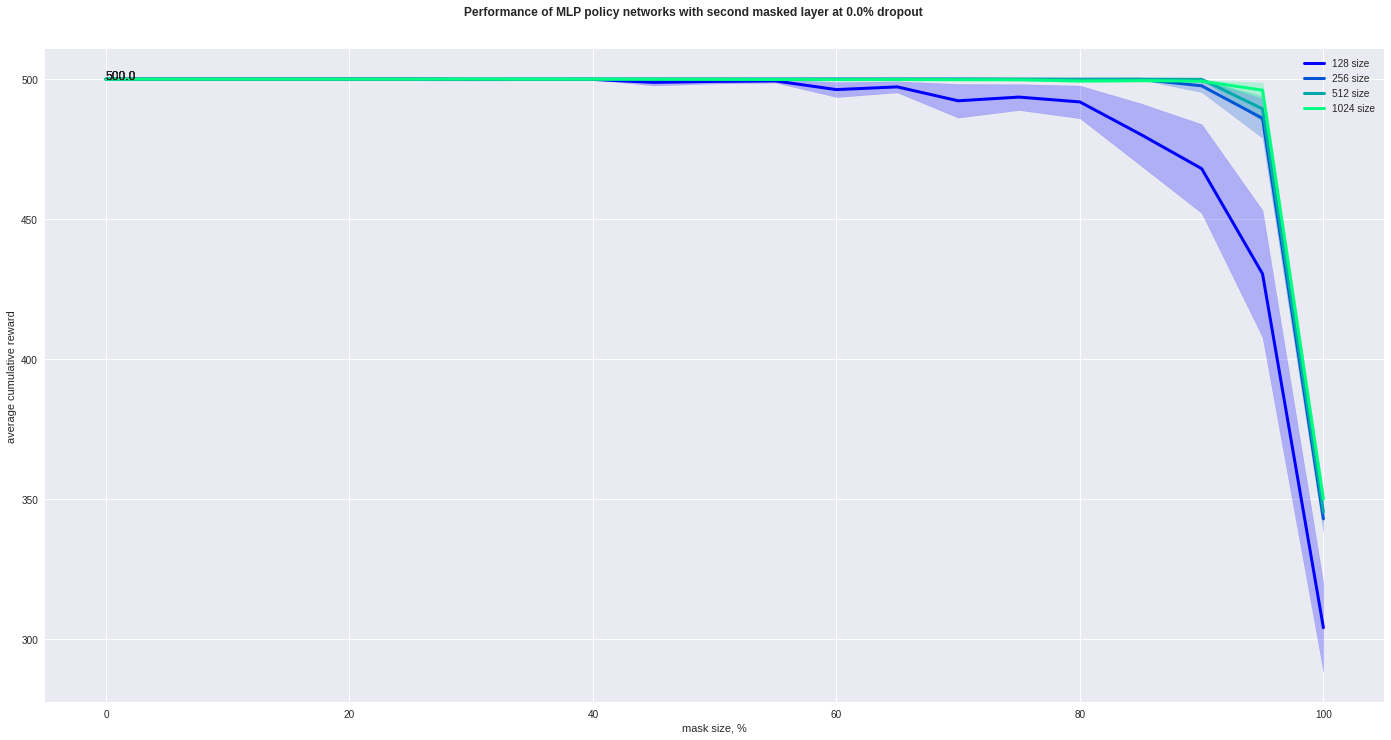

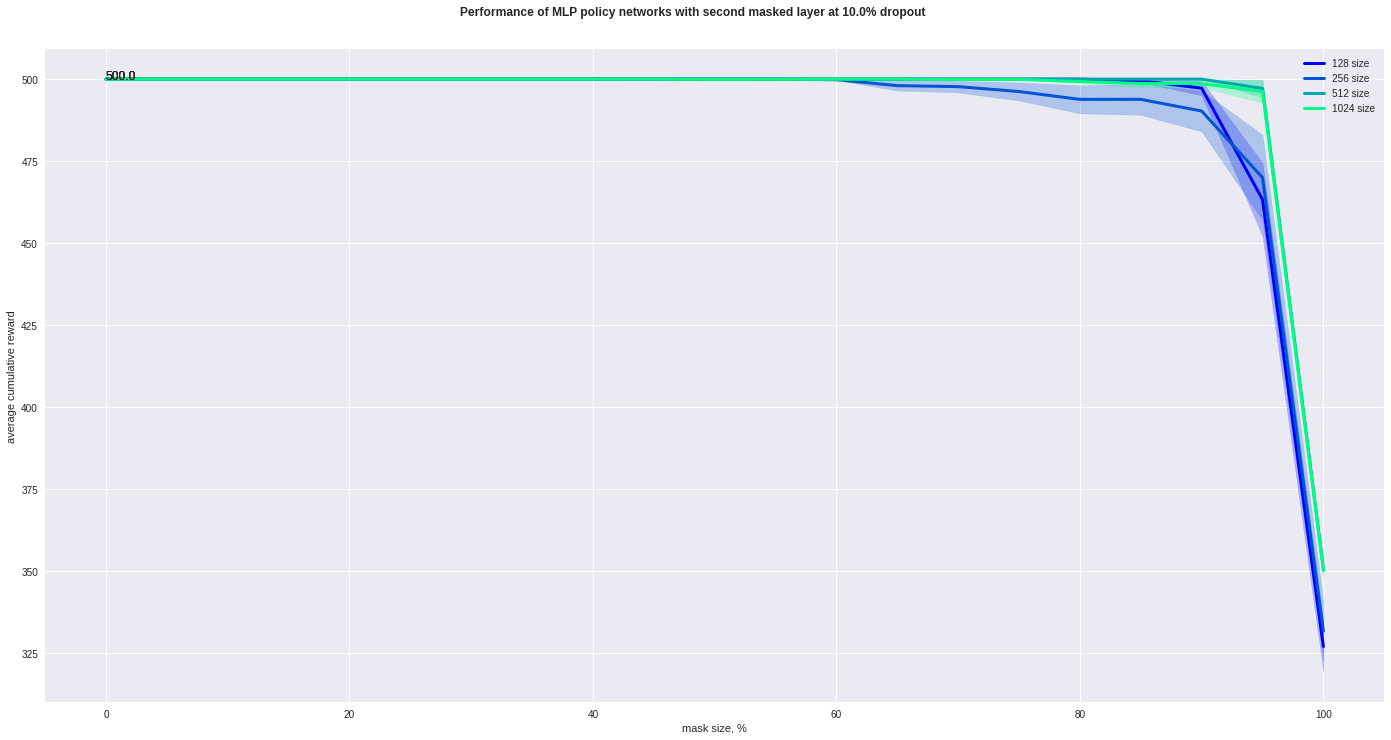

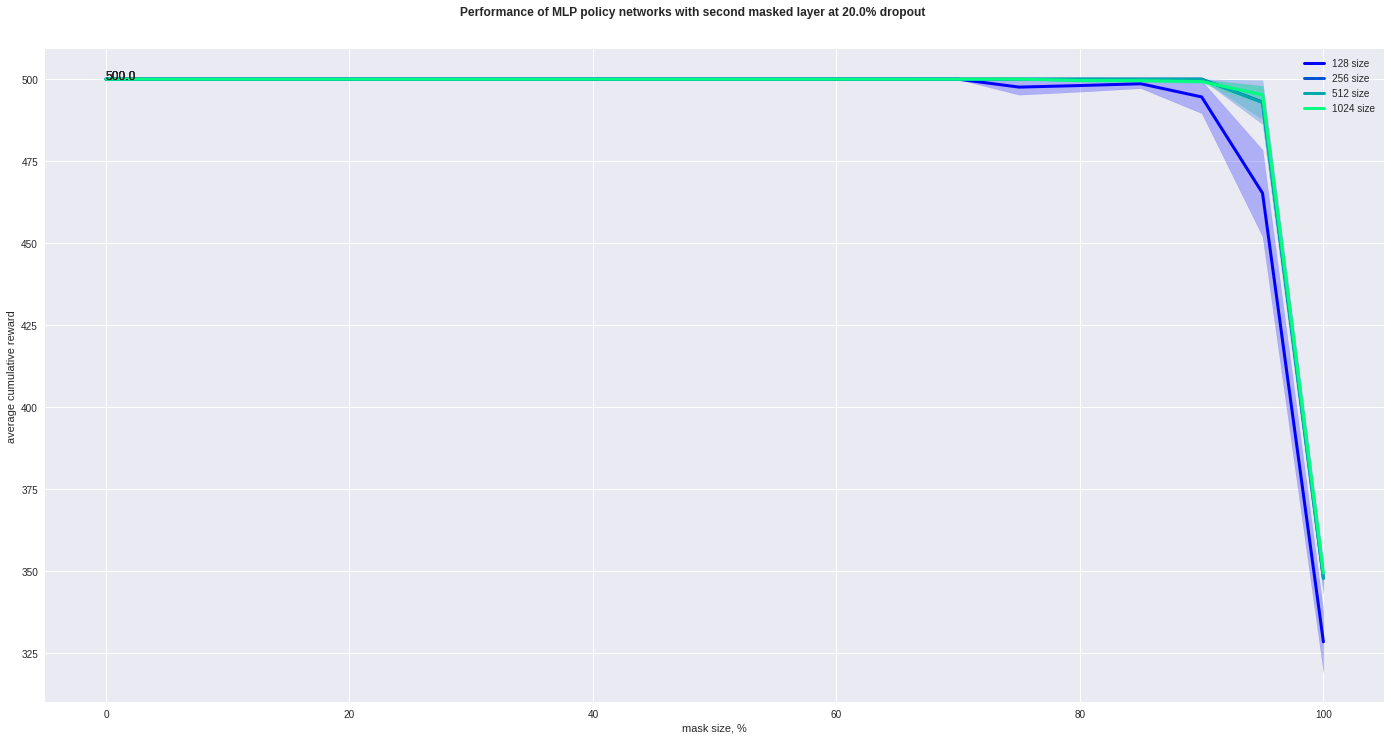

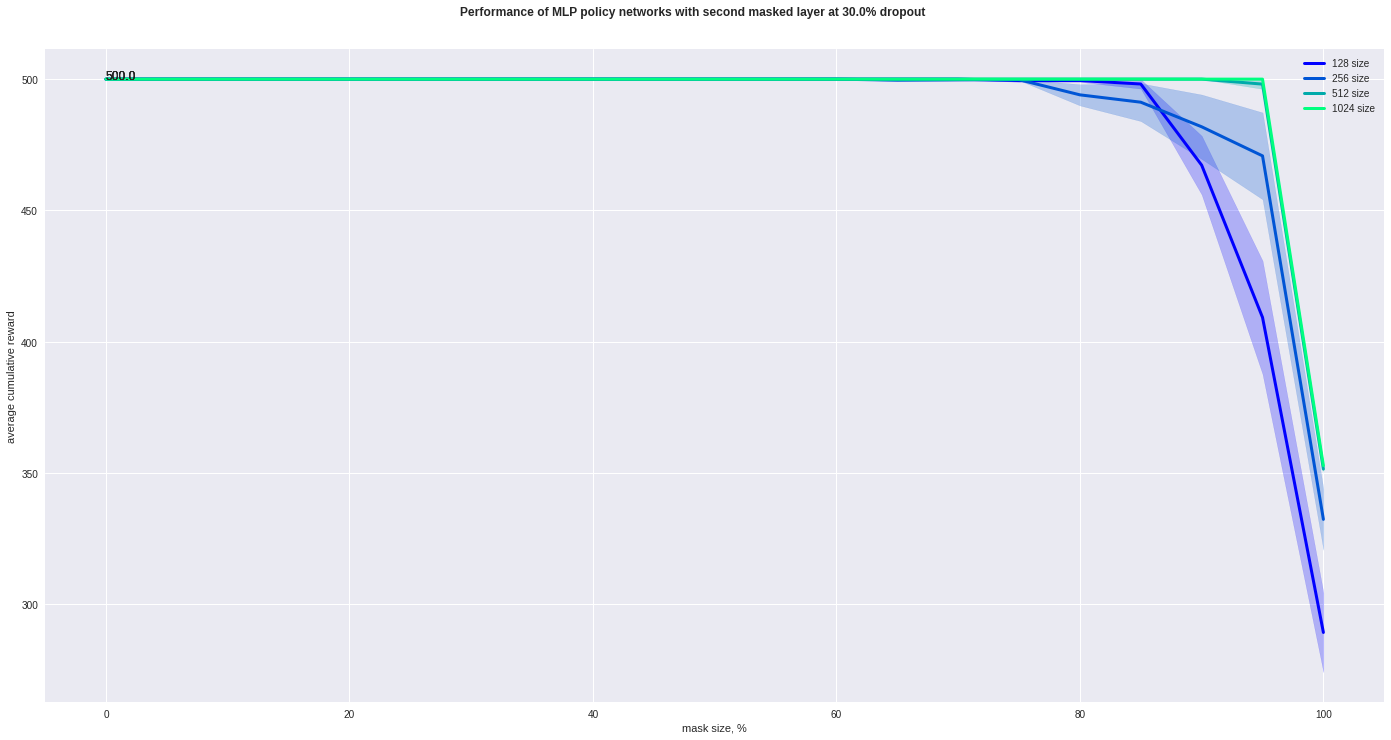

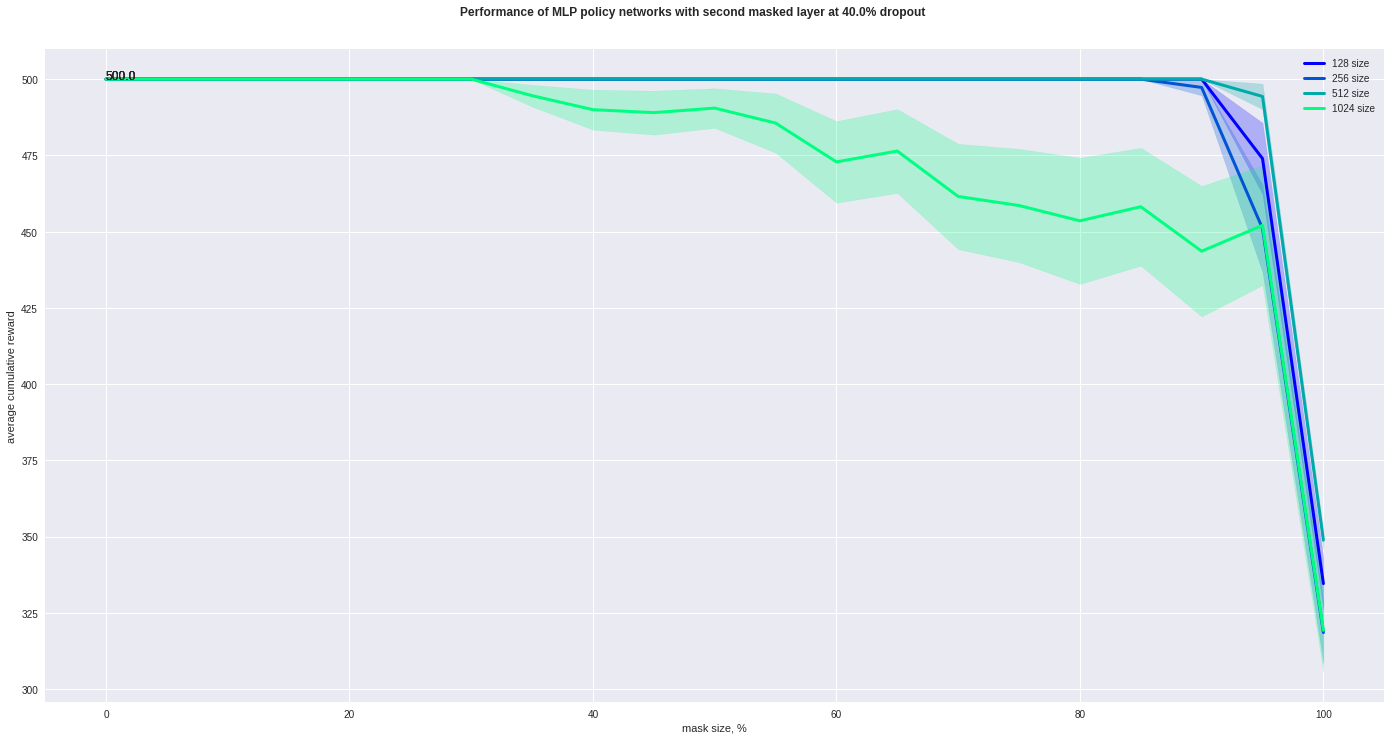

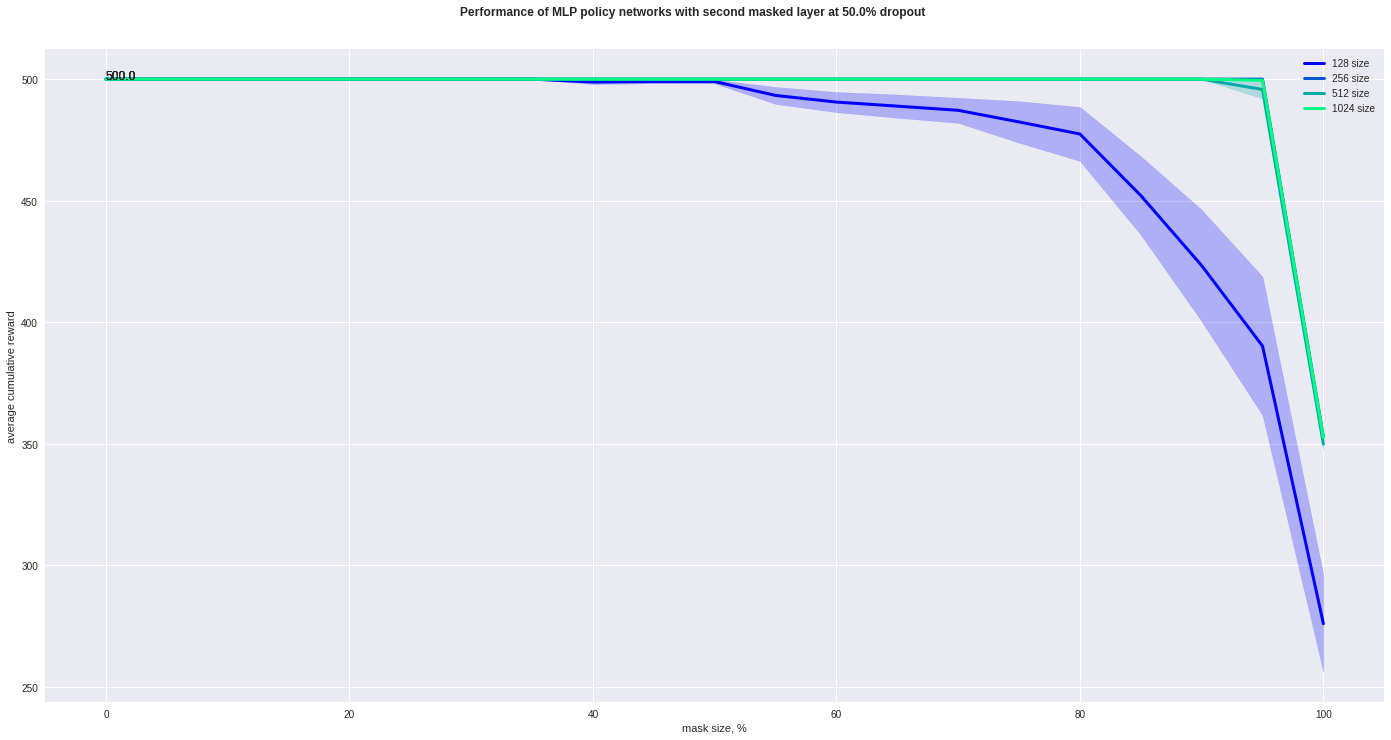

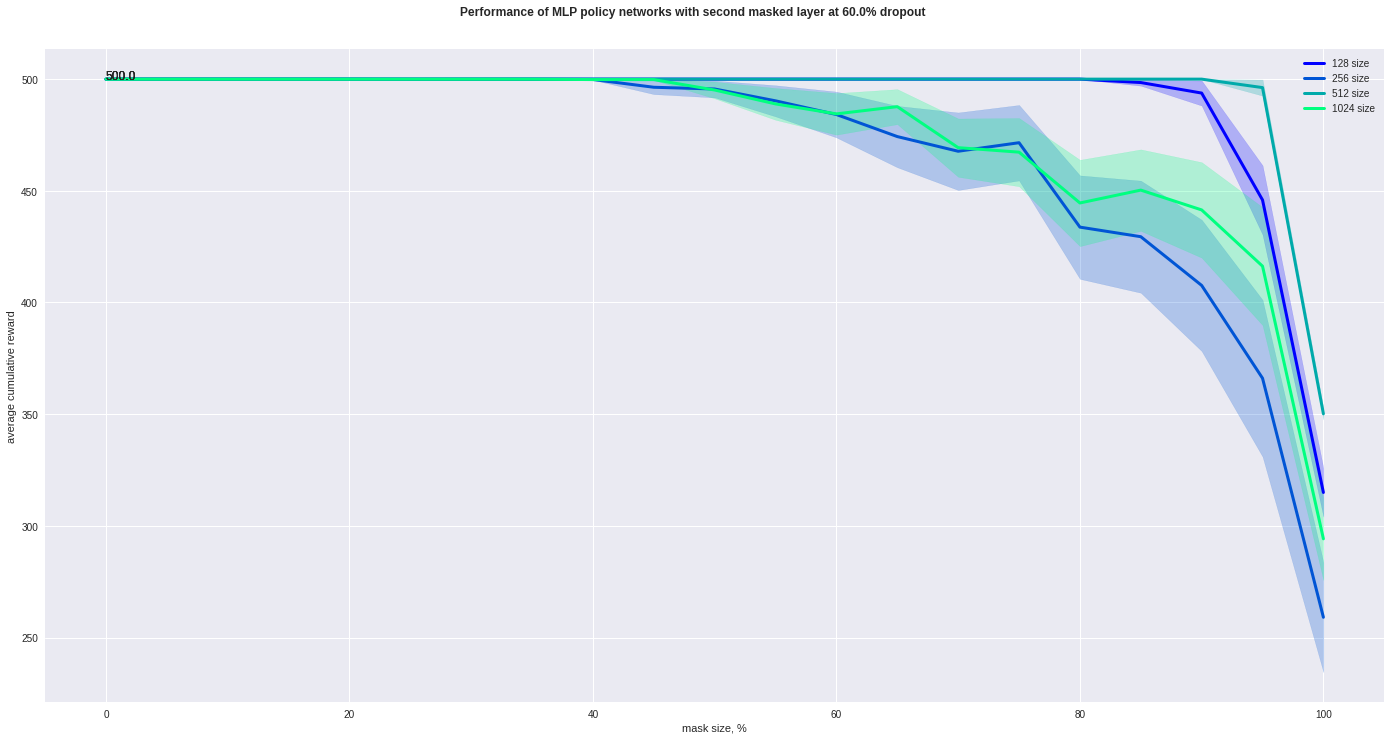

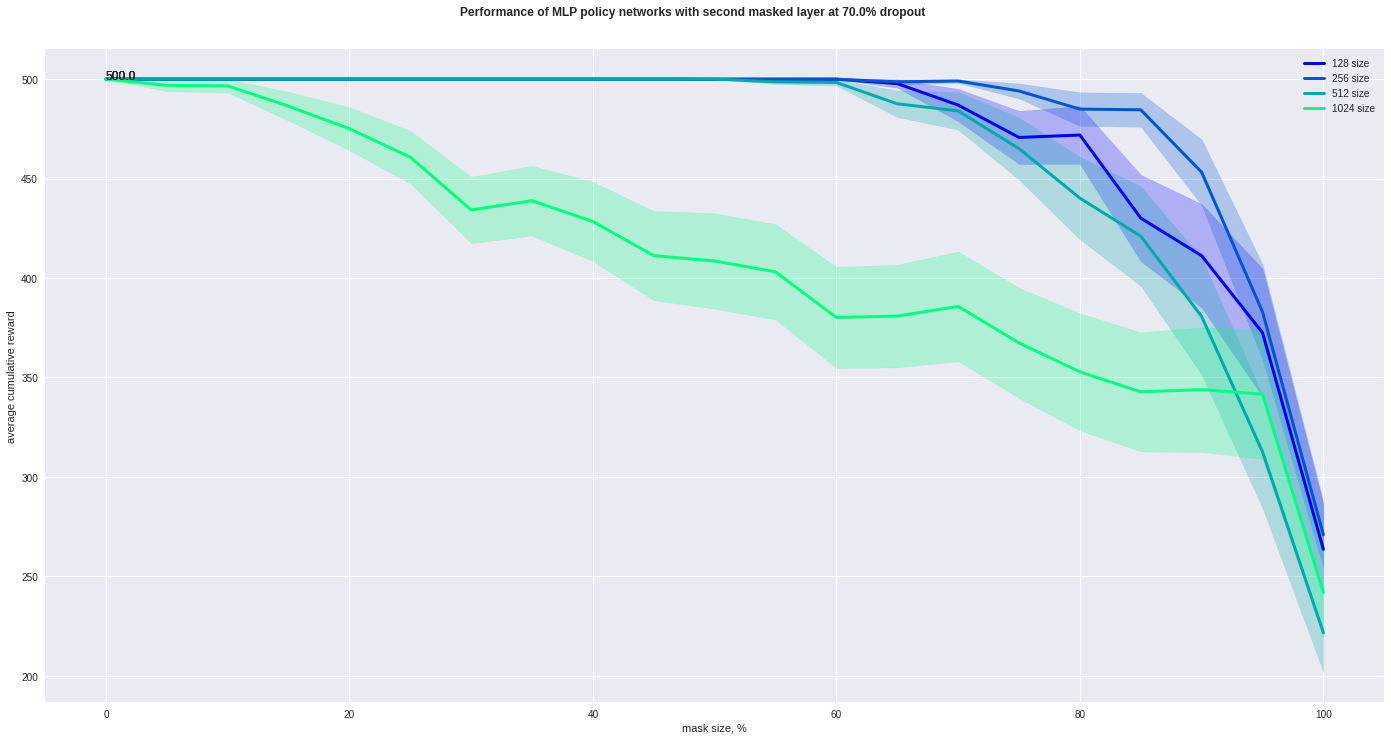

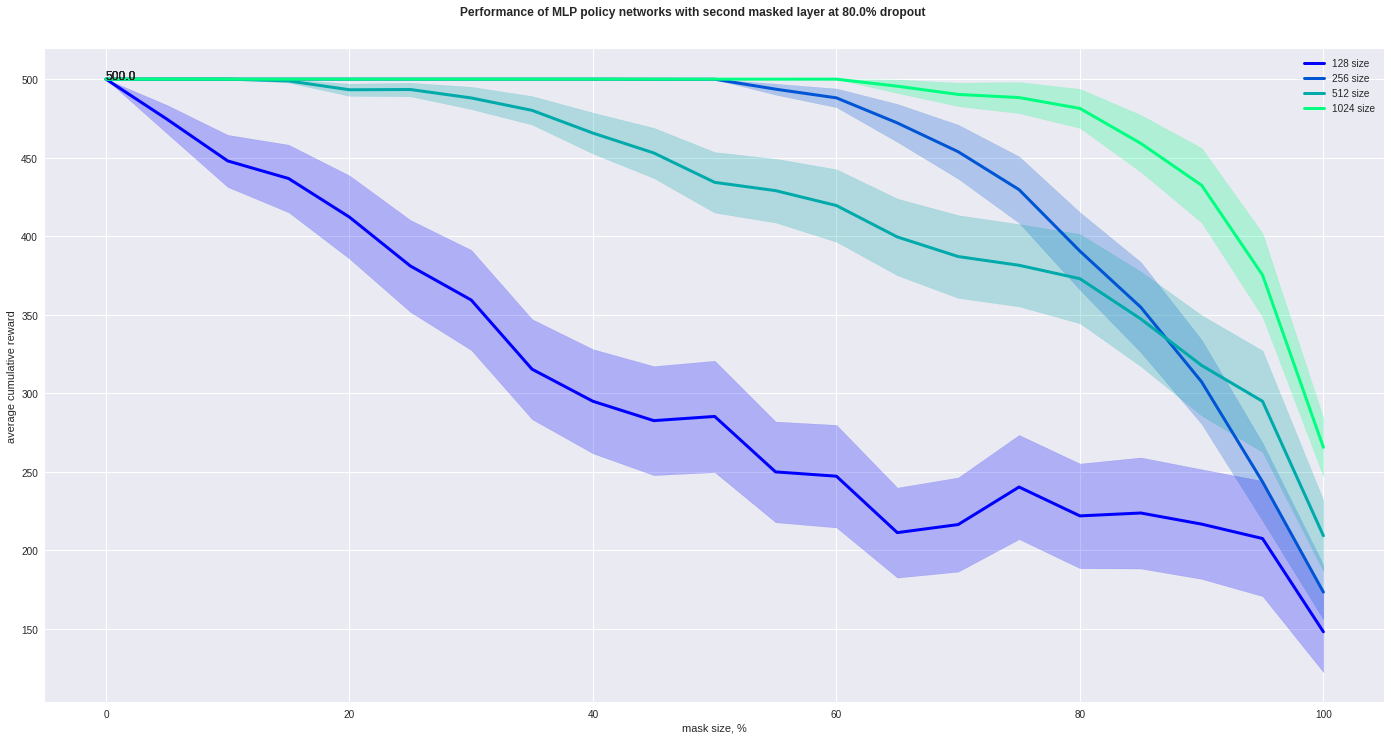

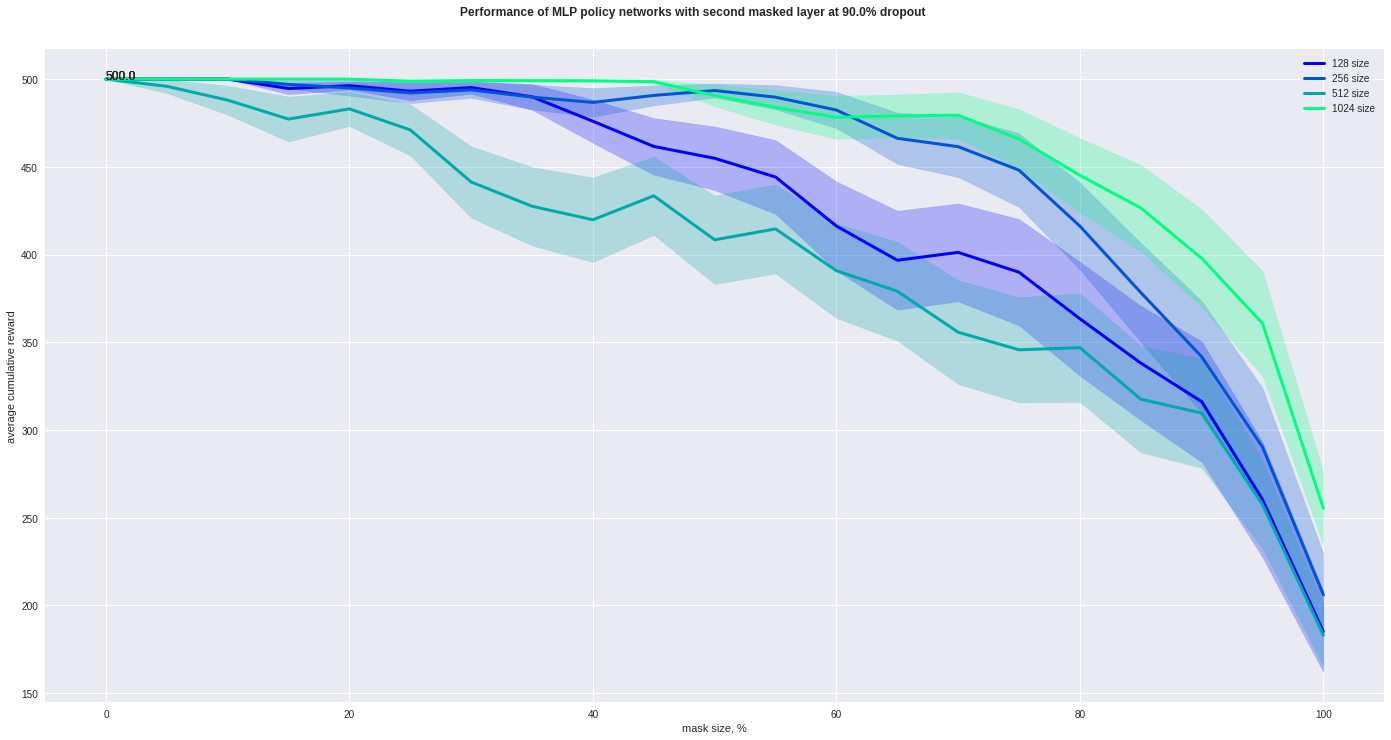

In [18]:
perf_rew_perdropout_plot(carpole_data_dropout, 'cartpole')

In [19]:
def parse_title(title: str) -> tuple:
    splitted = title.split(".")
    game = splitted[0]
    size = splitted[1].split("x")[0]
    dropout = float(title.split("_")[1])
    return game, size, dropout

In [20]:
def parser_masked_title(name: str) -> tuple:
    # CartPole-v1.128x128.dropout_0.8.mask_0.25.overtrained
    splitted = name.split('.')
    game = splitted[0]
    size = splitted[1].split("x")[0]
    split_underscore = name.split('_') #CartPole-v1.128x128.dropout, 0.8.mask, 0.25.overtrained
    dropout = split_underscore[1].replace('.mask', '')
    mask = split_underscore[2].replace('.overtrained', '')
    return game, size, float(dropout), float(mask)

In [21]:
def load_further_trained_data(path_f: str) -> dict: # (size, dropout): mask, (rew, std, steps)
    data = defaultdict(list)
    loaded_f = pickle.load(open(path_f, 'rb'))

    for name, vals in loaded_f.items():
        game, size, dropout, mask = parser_masked_title(name)
        (rew, std, steps) = vals[0]
        data[int(size), dropout].append((mask, rew, std, steps))

    return data

In [22]:
def concat_originial_further_trained_data(data_f, data_n_size) -> dict: # (size, dropout): ([masks], [rew_original], [std_original], [rew_masked], [std_masked], [steps])
    data_concat = defaultdict(list)
    """
        data_n -- size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]
    """
    for size, v in data_n_size.items():
        for val in v:
            dropout, x, mean_reward, std_reward = tuple(val)
            d = dropout[0]
            mean_reward_masked = mean_reward.copy()
            std_reward_masked = std_reward.copy()
            steps = [0]*len(x)
            eval_f = data_f[size, d]
            for (mask, rew, std, step) in eval_f:
                indx = np.where(x==mask)
                indx=indx[0][0]
                mean_reward_masked[indx] = rew
                std_reward_masked[indx] = std
                steps[indx] = step

            data_concat[(size, d)] = [x, mean_reward, std_reward, mean_reward_masked, std_reward_masked, steps]

    return data_concat

In [23]:
carpole_data_f = load_further_trained_data(os.path.join(PATH_RESULTS, 'evaluations_overtrained_cartpole.pickle'))
data_f_o = concat_originial_further_trained_data(carpole_data_f, carpole_data_size)

In [24]:
def steps(data:dict, size=128) -> np.ndarray:
    mean_steps = []

    for k, v in data.items():
        s, d = k
        steps = v[-1]
        if s == size: mean_steps.append(steps)
        
    return np.array(mean_steps)

In [25]:
recovery = steps(data_f_o, size=128)
recovery

array([[  0,   0,   0,   0,   0,   0,  10,  10,  10,  10,   0,  10,  10,
         10,  10,  10,  40,  10,  30,  60,  10],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  10,  10,   0,  10,  10,  60,  10],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  10,  10,  10,  30,  10, 100,  10],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  10,  10],
       [  0,   0,   0,   0,   0,   0,   0,   0,  10,  10,  10,  10,  10,
         10,  10,  10,  10,  10,  10,  10,  10],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  10,  10,  

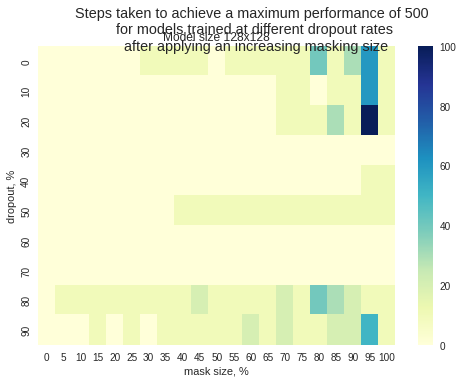

In [52]:
import seaborn as sns

plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
colors = plt.cm.winter(np.linspace(0, 1, 10))
plt.style.use('seaborn')
fig, ax1= plt.subplots()
ax1 = sns.heatmap(steps(data_f_o, size=128), cmap="YlGnBu")
ax1.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax1.set_xticklabels(np.arange(0, 105, 5))
ax1.set_title("Model size 128x128")
plt.suptitle("Steps taken to achieve a maximum performance of 500 \n for models trained at different dropout rates \n after applying an increasing masking size") # title is not correct
ax1.set_ylabel("dropout, %")
ax1.set_xlabel("mask size, %")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


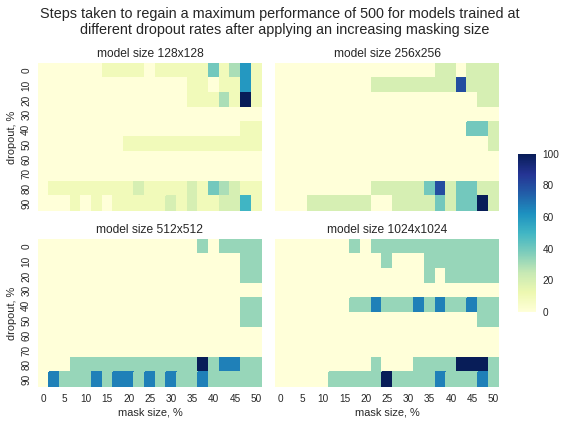

In [62]:
plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
colors = plt.cm.winter(np.linspace(0, 1, 10))
plt.style.use('seaborn')
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Steps taken to regain a maximum performance of 500 for models trained at \n different dropout rates after applying an increasing masking size", y=1.07)
binary = lambda x: bin(x).replace("0b", "")
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, size in enumerate([128, 256, 512, 1024]):
    ib = binary(i)
    if len(ib) == 1: ib = "0"+ib
    j, k = tuple([int(x) for x in ib])
    sns.heatmap(ax=ax[j, k], data=steps(data_f_o, size=size), cmap="YlGnBu", cbar=i==0, cbar_ax=None if i else cbar_ax)
    ax[j, k].set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax[j, k].set_xticklabels(np.arange(0, 105, 5))
    ax[j, k].set_title("model size {}x{}".format(size, size))
    if k == 0: ax[j, k].set_ylabel("dropout, %")
    if j == 1: ax[j, k].set_xlabel("mask size, %")

fig.tight_layout(rect=[0, 0, .9, 1])
plt.show()